In [2]:
# Import library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #turn off warning

from sklearn.preprocessing import StandardScaler

In [3]:
humanitarian = pd.read_csv("humanitarian-aid.csv")
humanitarian.head()

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Drop the "country" column as clustering is only for numerical values. 

In [4]:
humanitarian_df = humanitarian.drop('country', axis = 1)
print(len(humanitarian_df.columns))
print(humanitarian_df.head())
print(humanitarian_df.dtypes)

9
   child_mortality  exports  health  imports  income  inflation  \
0             90.2     10.0    7.58     44.9    1610       9.44   
1             16.6     28.0    6.55     48.6    9930       4.49   
2             27.3     38.4    4.17     31.4   12900      16.10   
3            119.0     62.3    2.85     42.9    5900      22.40   
4             10.3     45.5    6.03     58.9   19100       1.44   

   life_expectancy  total_fertility   gdpp  
0             56.2             5.82    553  
1             76.3             1.65   4090  
2             76.5             2.89   4460  
3             60.1             6.16   3530  
4             76.8             2.13  12200  
child_mortality    float64
exports            float64
health             float64
imports            float64
income               int64
inflation          float64
life_expectancy    float64
total_fertility    float64
gdpp                 int64
dtype: object


In [5]:
scaler = StandardScaler()
humanitarian_scaled = scaler.fit_transform(humanitarian_df)

# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(humanitarian_scaled)

PCA()

Text(0, 0.5, 'Eigenvalues')

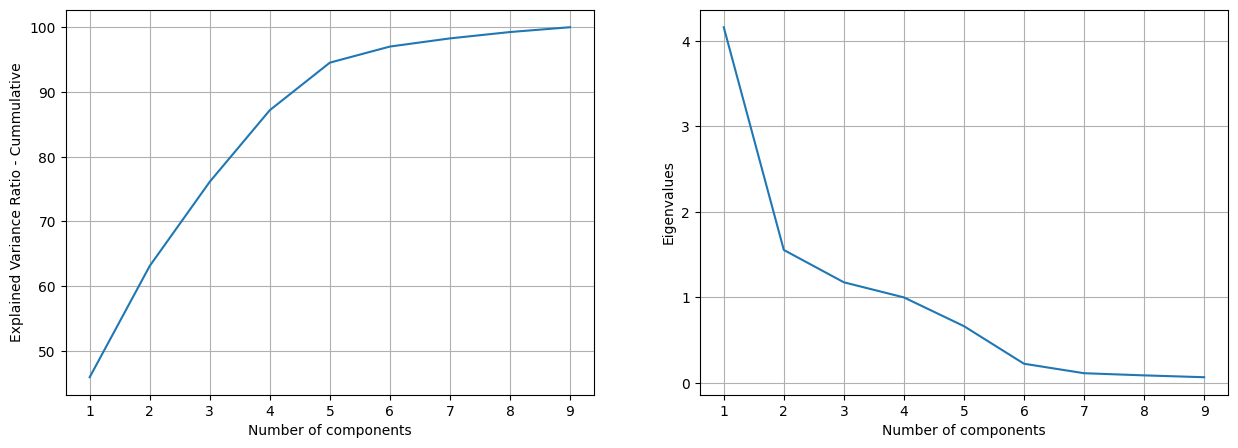

In [6]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 10), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 10), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [7]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

6

In [8]:
# Let's train the model with 95 % of the original dataset information

pca = PCA(n_components=0.95)
pca.fit(humanitarian_scaled)

humanitarian_scaled_pca = pca.transform(humanitarian_scaled)

In [9]:
len(humanitarian_scaled_pca[0])

6

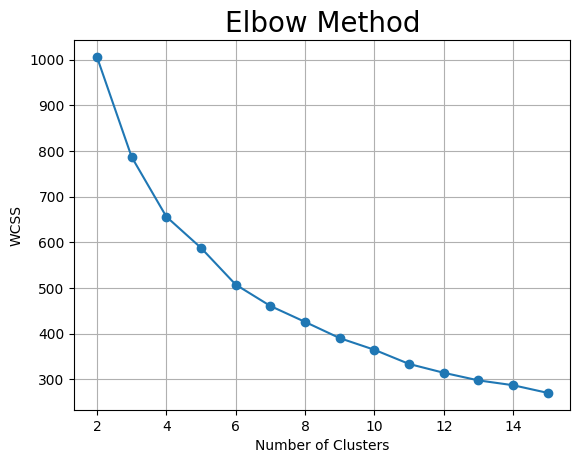

In [10]:
# Find the optimal number of clusters using Elbow Method
from sklearn.cluster import KMeans

wcss = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(humanitarian_scaled_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

---
**CONCLUSION**

Based on the plot above, the location of the elbow is in cluster 6.

In [11]:
# Function to create Silhouette Plot

import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.2963736460252067
For n_clusters = 3 The average silhouette_score is : 0.29796462418951314
For n_clusters = 4 The average silhouette_score is : 0.31536252220069483
For n_clusters = 5 The average silhouette_score is : 0.235072668844793
For n_clusters = 6 The average silhouette_score is : 0.2452728645739256
For n_clusters = 7 The average silhouette_score is : 0.26153310402486246
For n_clusters = 8 The average silhouette_score is : 0.218414771242151
For n_clusters = 9 The average silhouette_score is : 0.24229734544206305
For n_clusters = 10 The average silhouette_score is : 0.22580715959024894
For n_clusters = 11 The average silhouette_score is : 0.23347434398872177
For n_clusters = 12 The average silhouette_score is : 0.21802518009230212
For n_clusters = 13 The average silhouette_score is : 0.21964509332460158
For n_clusters = 14 The average silhouette_score is : 0.22536124318255613


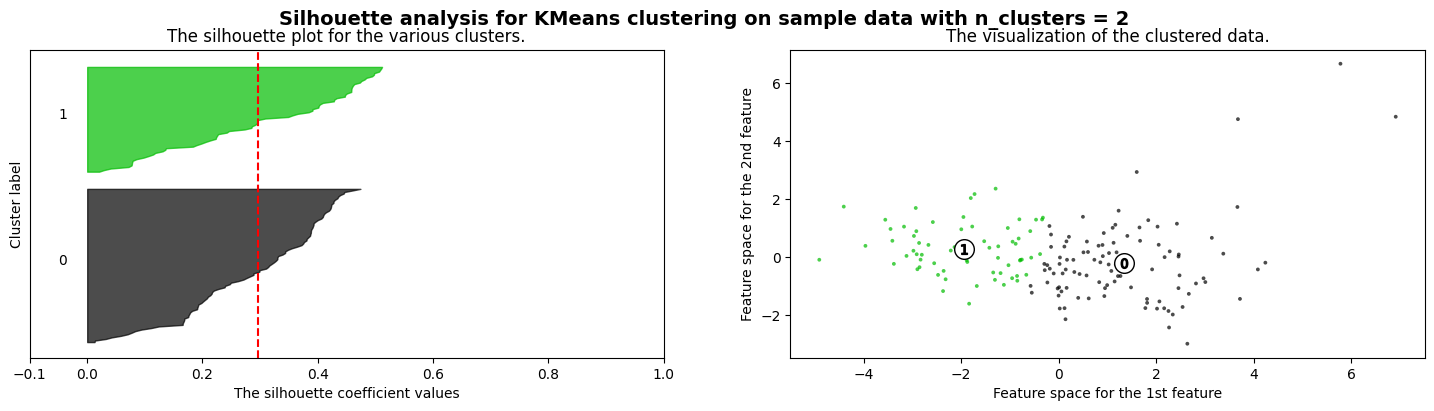

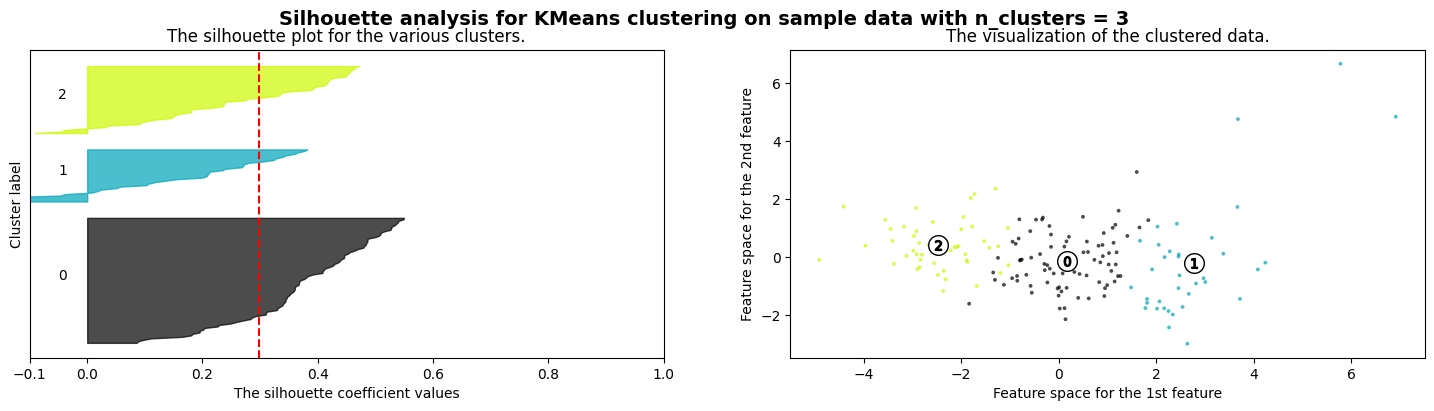

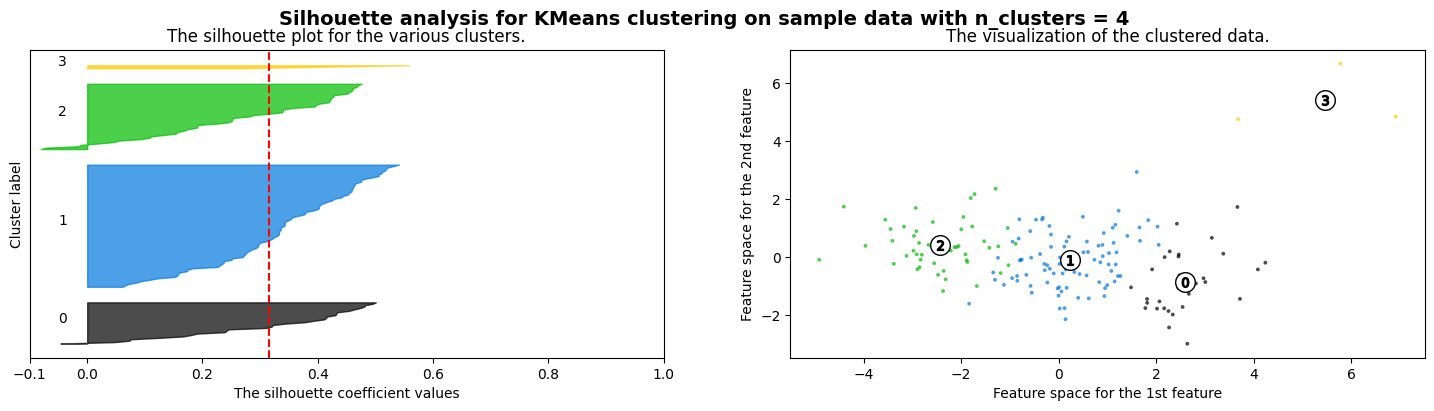

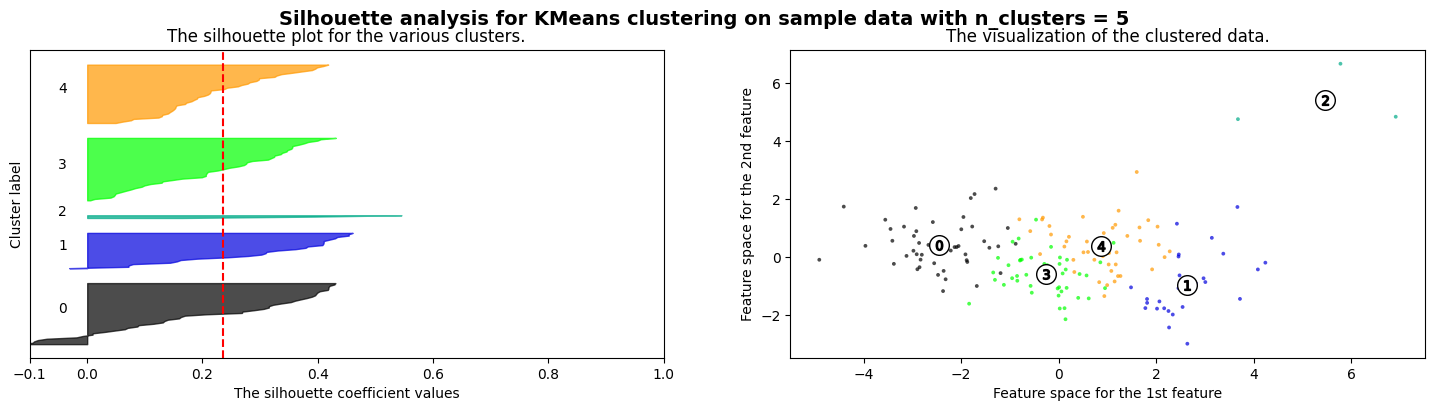

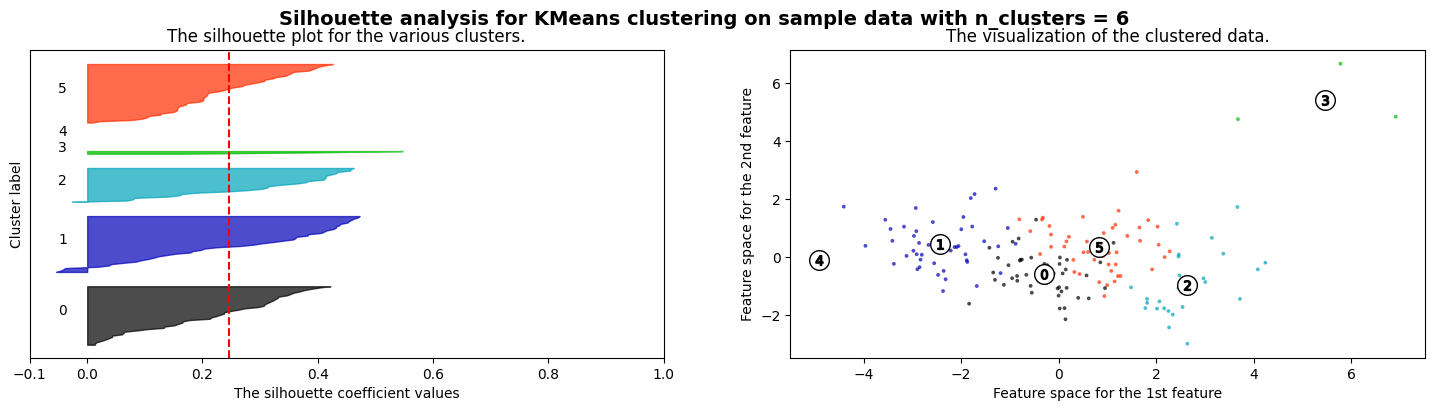

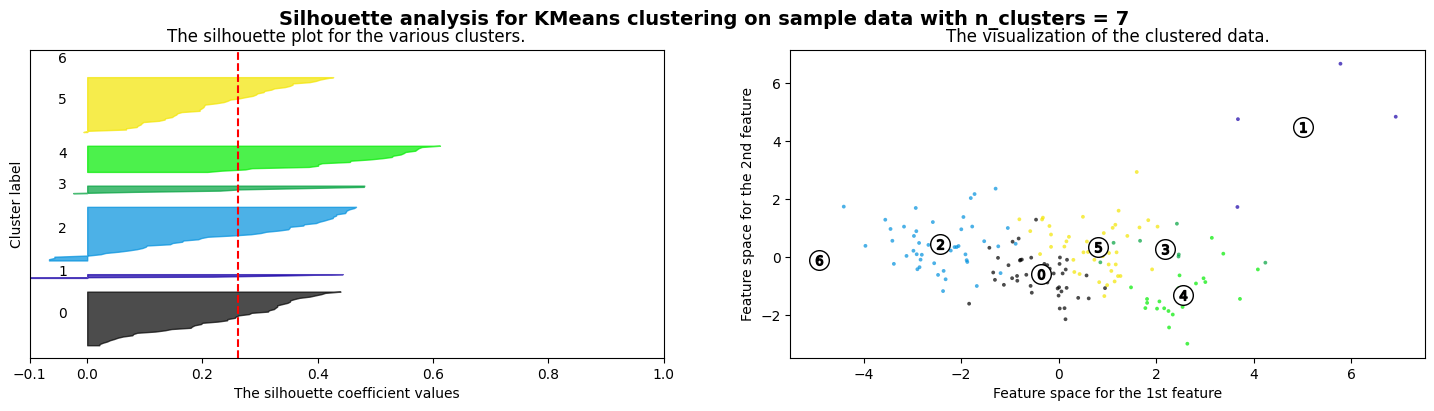

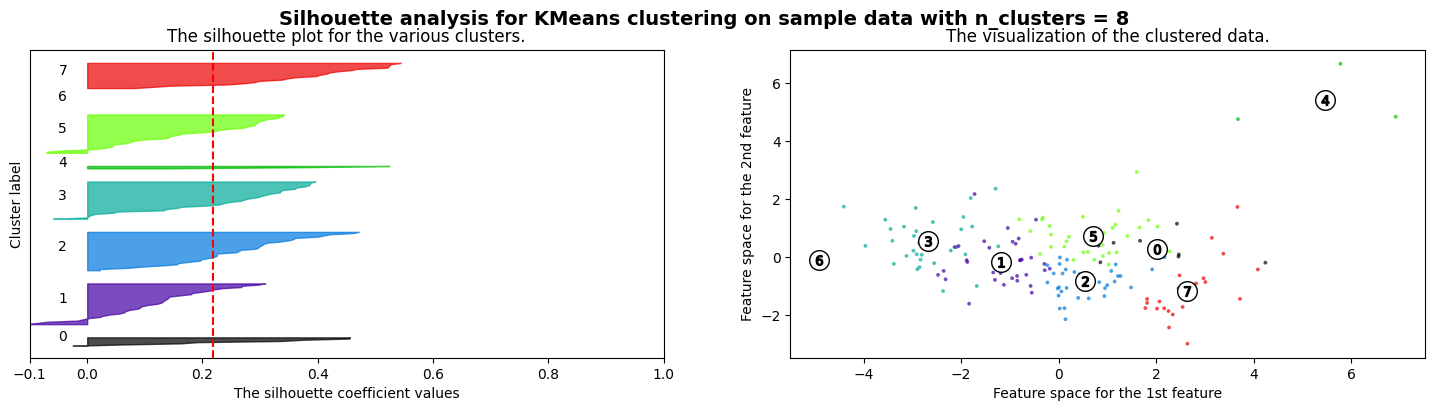

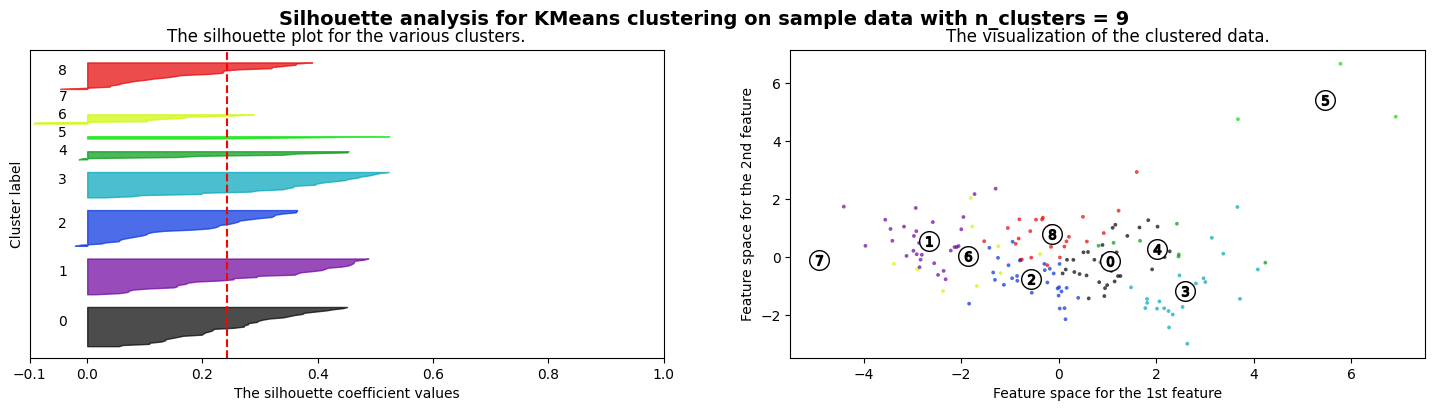

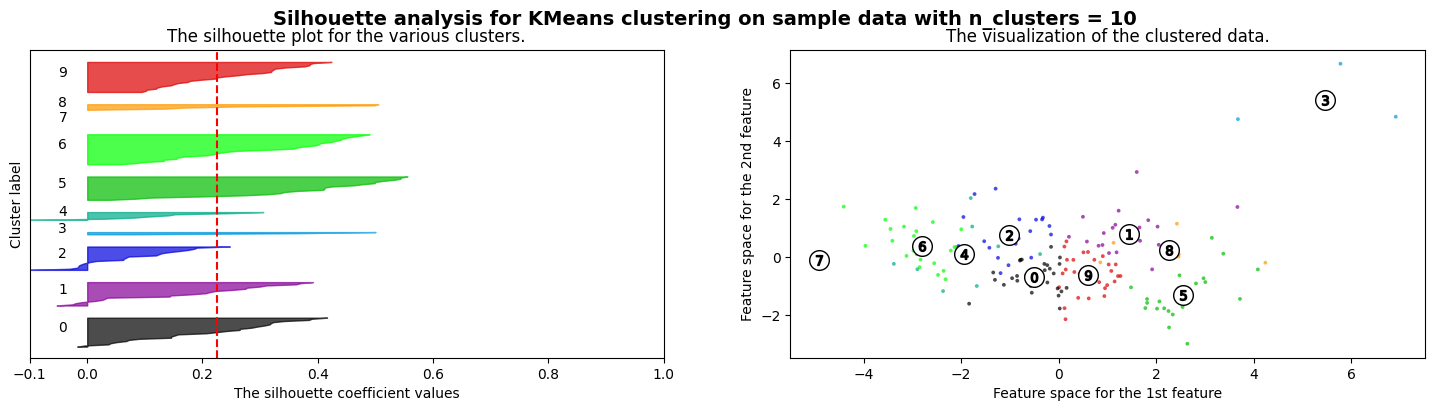

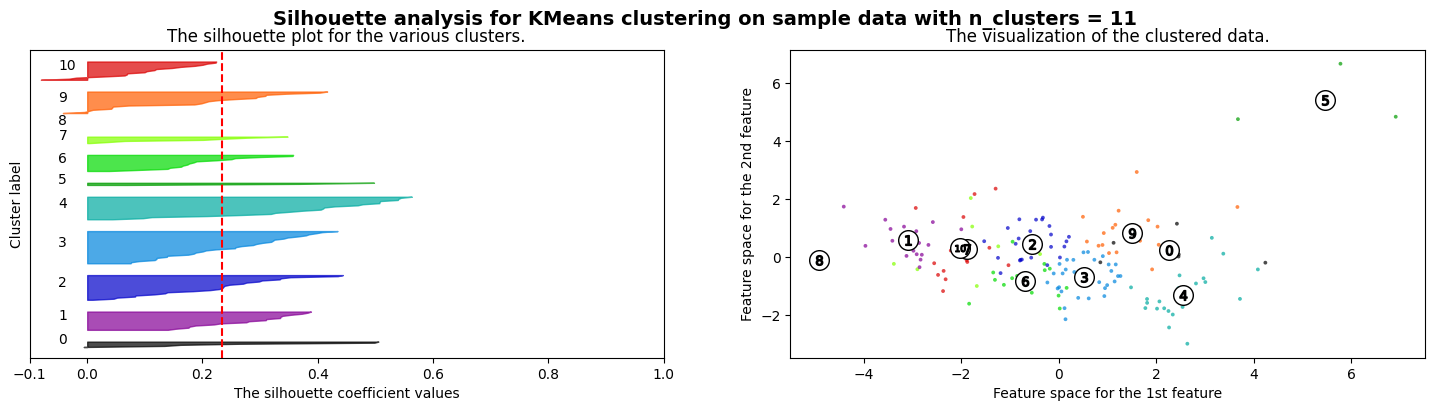

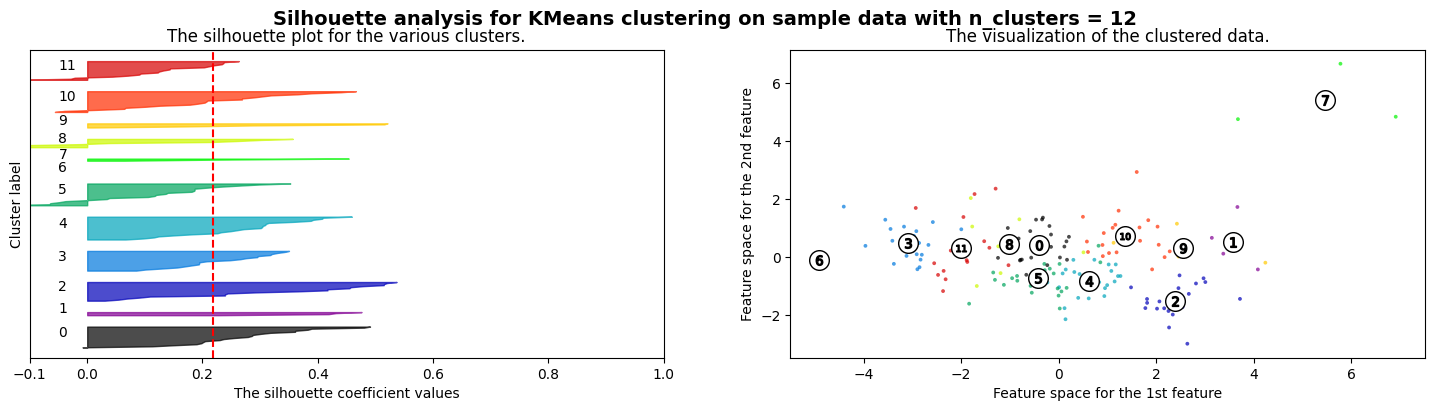

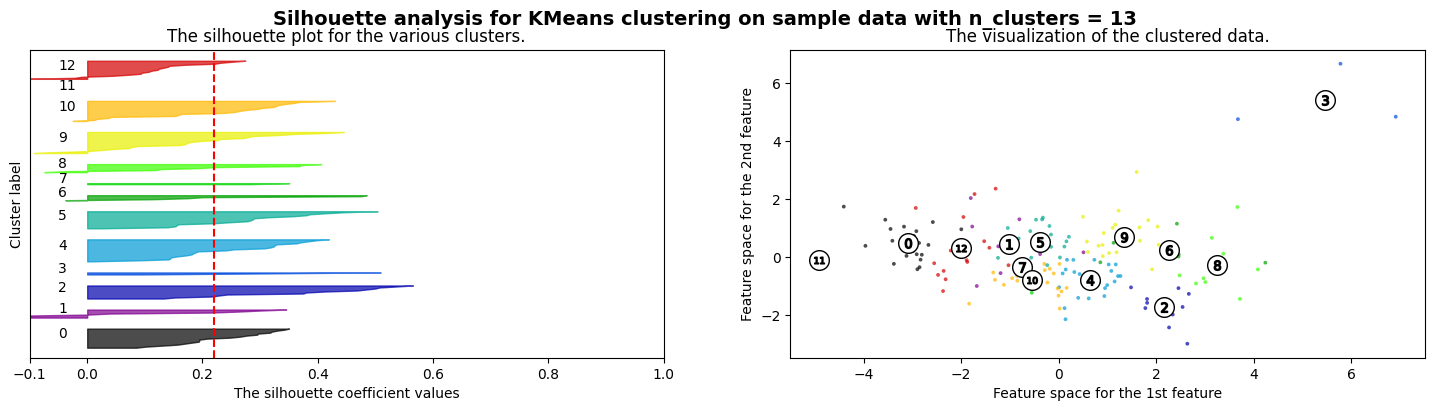

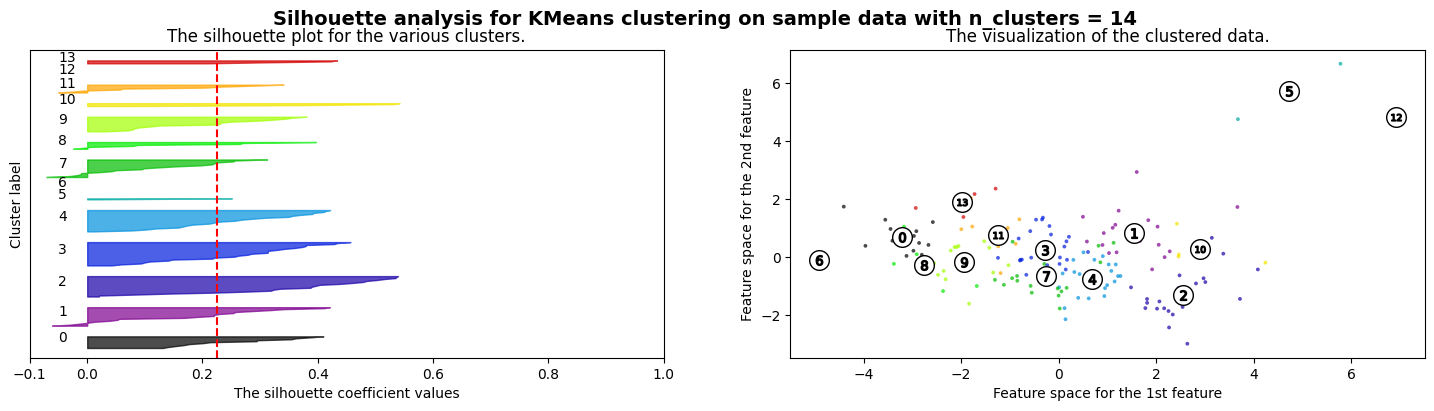

In [12]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), humanitarian_scaled_pca, random_state)

In [13]:
!pip install yellowbrick

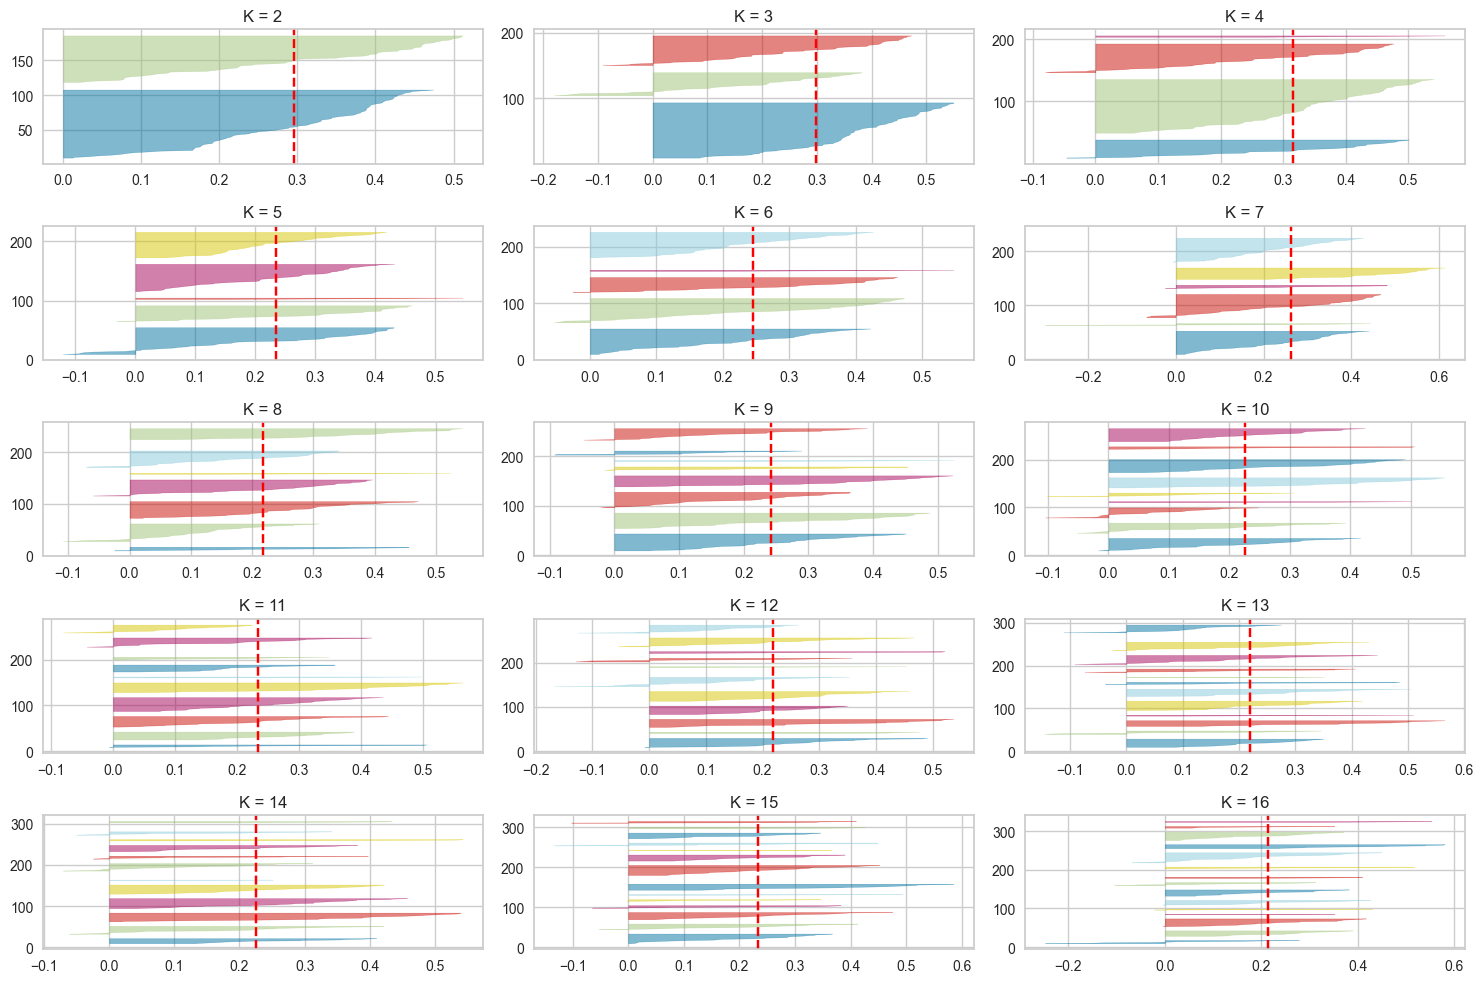

In [14]:
# Display the Silhouette Score and Plot Silhouette Plot
from yellowbrick.cluster import SilhouetteVisualizer

fig, axes = plt.subplots(5, 3, figsize=(15, 10))

# Loop for each plot
for i, ax in enumerate(axes.flatten()):

    # Initialize K-means clustering
    n_clusters = i + 2
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

    # Create SilhouetteVisualizer
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)

    # Fit visualizer to data
    visualizer.fit(humanitarian_scaled_pca)

    # Set title
    ax.set_title(f'K = {n_clusters}')

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
# Train with optimal number of clusters

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
pred = km.fit_predict(humanitarian_scaled_pca)
pred

array([2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 1,
       0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       2, 1, 1, 3, 1, 2, 2, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 3, 1, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2], dtype=int32)

In [16]:
humanitarian['cluster'] = pred
humanitarian

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,2


<Axes: >

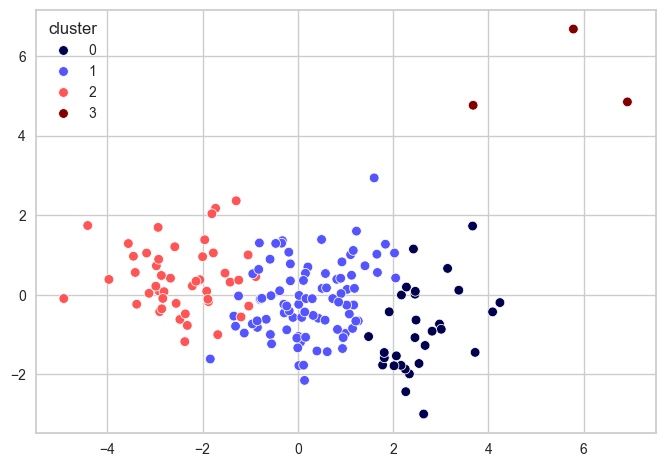

In [17]:
# Cluster visualization in 2D

pca_2d = PCA(n_components=2)
pca_2d.fit(humanitarian_scaled)

humanitarian_scaled_pca_2d = pca_2d.fit_transform(humanitarian_scaled)

sns.scatterplot(x=humanitarian_scaled_pca_2d[:,0], y=humanitarian_scaled_pca_2d[:,1], hue=humanitarian['cluster'], palette='seismic')

In [24]:
cols_to_check = ["life_expectancy", "health", "child_mortality", "income", "gdpp"]

for j in cols_to_check:
    for cluster_label in range(0, 4):
        cluster_data = humanitarian.query(f'cluster == {cluster_label}')
        cols_data_mean = cluster_data[j].mean().round(2)
        print(f"Average {j} in cluster {cluster_label}: {cols_data_mean}")

Average life_expectancy in cluster 0: 80.38
Average life_expectancy in cluster 1: 72.94
Average life_expectancy in cluster 2: 59.19
Average life_expectancy in cluster 3: 81.43
Average health in cluster 0: 9.17
Average health in cluster 1: 6.24
Average health in cluster 2: 6.39
Average health in cluster 3: 6.79
Average child_mortality in cluster 0: 4.95
Average child_mortality in cluster 1: 21.39
Average child_mortality in cluster 2: 92.96
Average child_mortality in cluster 3: 4.13
Average income in cluster 0: 45250.0
Average income in cluster 1: 12968.62
Average income in cluster 2: 3942.4
Average income in cluster 3: 64033.33
Average gdpp in cluster 0: 43333.33
Average gdpp in cluster 1: 6919.1
Average gdpp in cluster 2: 1922.38
Average gdpp in cluster 3: 57566.67


- Kerapian, bikin group by pakai dataframe
- Di awal, bisa cek sebelum scaling, lakukan EDA (kesimpulan awal)
- Tambah narasi di feature engineering (silhouette score)
- Insights (bikin chart), e.g. berdasarkan rata-rata
- Lihat distribusi data (e.g. boxplot). Cluster 0, 1, 2, 3. Kalau byk outlier lebih baik pakai median
- Tambah EDA di atas soal.
- Kesimpulan model.
- Handling outliers.
- Kekurangan dan kelebihan dari model. Bisa dibandingkan dengan model lain di analisis.